In [ ]:
import tensorflow as tf

In [ ]:
print(tf.__version__)
tf.config.list_physical_devices('GPU')

2.4.1


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
from google.colab import drive
drive.mount('/gdrive', force_remount=True)

Mounted at /gdrive


In [ ]:
path = '/gdrive/My Drive/'

<h1> Build CNN Model </h1>

In [ ]:
from keras import Sequential
from keras import models, layers, optimizers, utils
from keras.layers import Dropout, Activation, Dense
from keras.layers import Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.models import load_model

In [ ]:
# 이미지 크기 지정

IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

In [ ]:
# 모델 생성

def build_model():

    learning_rate = 0.0001
    model = Sequential()
    model.add(ZeroPadding2D((1,1),input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(256, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(ZeroPadding2D((1,1)))
    model.add(Convolution2D(512, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2,2), strides=(2,2)))
    
    model.add(Convolution2D(4096, (7, 7), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(4096, (1, 1), activation='relu'))
    model.add(Dropout(0.5))
    model.add(Convolution2D(2622, (1, 1)))
    model.add(Flatten())
    model.add(Activation('softmax'))
    
    return model

In [ ]:
model = build_model()
model.load_weights(path+'/vgg_face_weights.h5')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_13 (ZeroPaddi (None, 226, 226, 3)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
zero_padding2d_14 (ZeroPaddi (None, 226, 226, 64)      0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
zero_padding2d_15 (ZeroPaddi (None, 114, 114, 64)      0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 112, 112, 128)    

In [ ]:
from tensorflow.keras.models import Model
face_descriptor = Model(inputs=model.layers[0].input, outputs=model.layers[-2].output)

<h1> Load Image </h1>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import keras
from keras.preprocessing.image import load_img
import random
import os, sys
from keras.preprocessing import image
from PIL import Image

In [ ]:
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array
from numpy import expand_dims

In [ ]:
import cv2
import sys

In [ ]:
# 이미지에서 얼굴 영역만 크롭한다.

def image_load(imagePath):
    global cropped_face
    cascPath = "/gdrive/My Drive/haarcascade_frontalface_default.xml"
    faceCascade = cv2.CascadeClassifier(cascPath)

    image = cv2.imread(imagePath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minSize=(15, 15))

    for (x, y, w, h) in faces:
        cropped_face = image[y:y+h, x:x+w]
    
    return cropped_face

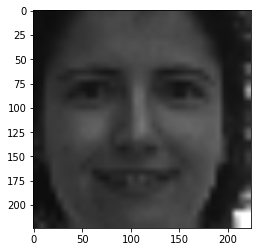

In [ ]:
# 이미지 로드 확인

tmpPath = "/gdrive/My Drive/02_face_training/0124_0002.BMP"
tmp_image = image_load(tmpPath)
tmp_image = cv2.resize(tmp_image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
plt.imshow(tmp_image)

In [ ]:
tmp_image = image_load(tmpPath)
tmp_image = (tmp_image / 255.).astype(np.float32)
tmp_image = cv2.resize(tmp_image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)

embedding_vector = face_descriptor.predict(np.expand_dims(tmp_image, axis=0))[0]

In [ ]:
print(tmp_image.shape)
print(embedding_vector.shape)

(224, 224, 3)
(2622,)


In [ ]:
# 테스트데이터 파일을 숫자 정렬
import natsort
train_order = os.listdir(path+'02_face_training')
train_order = natsort.natsorted(train_order)

In [ ]:
# 이미지를 350개의 카테고리로 분류
nb_classes = 350

label= []
embeddings = np.zeros((nb_classes*3, 2622))

i = 0

for filename in train_order:
    category = filename.split("_")[0]
    imagePath = path + '/02_face_training/' + filename
    
    image = image_load(imagePath)
    image = (image / 255.).astype(np.float32)
    image = cv2.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    
    # face_descriptor 모델에서 나온 특징점들을 저장
    embeddings[i]= face_descriptor.predict(np.expand_dims(image, axis=0))[0]
    label.append(int(category)-1)
    i += 1

In [ ]:
# 훈련데이터셋 형성
train_data = [embeddings, label]
(X, Y) = (train_data[0], train_data[1])

In [ ]:
X = np.asarray(X, dtype = np.uint8)
Y = np.asarray(Y, dtype = np.uint8)

In [ ]:
print(X.shape)

(1050, 2622)


<h1> Feature Distance </h1>

In [ ]:
# 테스트 데이터 간 거리 계산 함수
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

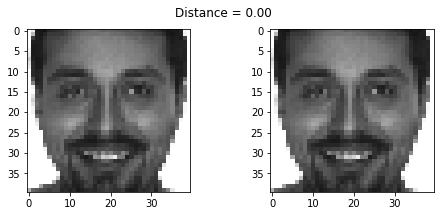

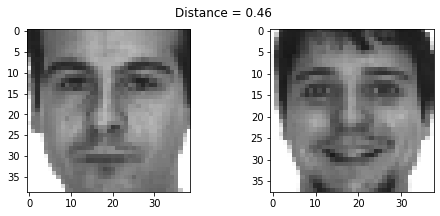

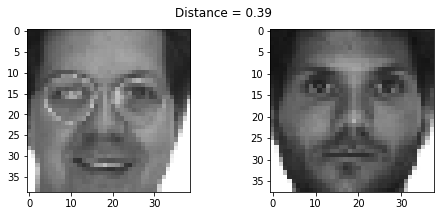

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,3))
plt.suptitle(f'Distance = {distance(embeddings[10], embeddings[10]):.2f}')
plt.subplot(121)
plt.imshow(image_load(path +'02_face_training/0004_0002.BMP'))
plt.subplot(122)
plt.imshow(image_load(path +'02_face_training/0004_0002.BMP'))

plt.figure(figsize=(8,3))
plt.suptitle(f'Distance = {distance(embeddings[0], embeddings[5]):.2f}')
plt.subplot(121)
plt.imshow(image_load(path +'02_face_training/0001_0001.BMP'))
plt.subplot(122)
plt.imshow(image_load(path +'02_face_training/0002_0002.BMP'))

plt.figure(figsize=(8,3))
plt.suptitle(f'Distance = {distance(embeddings[8], embeddings[12]):.2f}')
plt.subplot(121)
plt.imshow(image_load(path +'02_face_training/0003_0002.BMP'))
plt.subplot(122)
plt.imshow(image_load(path +'02_face_training/0005_0001.BMP'))

In [ ]:
# 10개의 데이터마다 train과 test 세트로 분리
train_idx = np.arange(nb_classes*3) % 10 != 0
test_idx = np.arange(nb_classes*3) % 10 == 0

X_train = embeddings[train_idx]
X_test = embeddings[test_idx]

targets = np.array(label)

y_train = Y[train_idx]
y_test = Y[test_idx]

In [ ]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_train_label = encoder.fit_transform(y_train)
y_test_label = encoder.transform(y_test)

In [ ]:
# 3번의 cross validation을 통해 training set score 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC

# SVM으로 학습 데이터 훈련
svc = LinearSVC(C = 10) 
svc.fit(X_train, y_train_label)
y_pred = svc.predict(X_test)

print("Accuracy on training set: {:.2f}".format(cross_val_score(svc, X_train, y_train_label, cv=3)))
print("Accuracy on test set: {:.2f}".format(svc.score(X_test, y_test_label)))

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:667: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  % (min_groups, self.n_splits)), UserWarning)


Accuracy on training set: {:.2f} [0.93650794 0.94920635 0.93333333]
Accuracy on test set: {:.2f} 0.9333333333333333


In [ ]:
# KNN으로 학습 데이터 훈련
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
knn.fit(X_train, y_train_label)

print("Accuracy on training set: {:.2f}".format(knn.score(X_train, y_train_label)))
print("Accuracy on test set: {:.2f}".format(knn.score(X_test, y_test_label)))

Accuracy on training set: 0.99
Accuracy on test set: 0.90


In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score

print("accuracy: {:.2f}".format(accuracy_score(y_test_label, y_pred)))
print("Precision: {:.2f}".format(precision_score(y_test_label, y_pred, average = 'micro')))
print("Recall: {:.2f}".format(recall_score(y_test_label, y_pred, average = 'micro')))
print("F1-score: {:.2f}".format(f1_score(y_test_label, y_pred, average = 'micro')))

accuracy: 0.93
Precision: 0.93
Recall: 0.93
F1-score: 0.93


<h1> Test </h1>

In [ ]:
# 테스트데이터 파일을 숫자 순으로 정렬
import natsort
order_list = os.listdir(path+'02_face_test')
order_list = natsort.natsorted(order_list)

In [ ]:
test_embed = np.zeros((700, 2622))

i = 0
for filename in order_list:
    imagePath = path + '/02_face_test/' + filename
    
    test_image = image_load(imagePath)
    test_image = (test_image / 255.).astype(np.float32)
    test_image = cv2.resize(test_image, (IMAGE_WIDTH, IMAGE_HEIGHT), cv2.INTER_AREA)
    
    test_embed[i]= face_descriptor.predict(np.expand_dims(test_image, axis=0))[0]
    test_data.append(np.array(test_image))
    i += 1

In [ ]:
test_embed.shape

(700, 2622)

In [ ]:
svc_predict = svc.predict(test_embed)
knn_predict = knn.predict(test_embed)

<h1> SVM Result </h1>

In [ ]:
import csv
f = open(path + 'face_result_svc.csv', 'w', newline='')
wr = csv.writer(f)

In [ ]:
wr.writerow(['Image', 'Answer'])
for i in range(len(svc_predict)):
  wr.writerow([i+1, svc_predict[i]+1])

In [ ]:
f.close()

<h1> KNN Result </h1>

In [ ]:
f = open(path + 'face_result_knn.csv', 'w', newline='')
wr = csv.writer(f)

In [ ]:
wr.writerow(['Image', 'Answer'])
for i in range(len(knn_predict)):
  wr.writerow([i+1, knn_predict[i]+1])

In [ ]:
f.close()